In [1]:
import sys

In [3]:
sys.path.append("../code/")

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
import sys, traceback
print sys.argv
from docopt import docopt
import pandas as pd
import time
import numpy as np
import os
np.random.seed(0)

from common_functions import create_region_df, features_dict,create_feature_combinations, create_df_main
from matrix_factorisation import nmf_features, transform, transform_2, \
    preprocess, get_static_features, get_static_features_region_level


['/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/nipunbatra/Library/Jupyter/runtime/kernel-6d24d980-c3c9-475e-9ec1-3ef4790ed501.json']


In [38]:
year=2014
seed = 0
test_home=54
train_regions = ["Austin","Boulder","SanDiego"]
train_fraction_dict = {region:0 for region in train_regions}
train_fraction_dict['SanDiego']=1.0
test_region = 'SanDiego'
feature_list = ['energy','home']
appliance="hvac"
feature_comb = ['None']

In [39]:
def factorise(year, seed, test_home, train_regions, train_fraction_dict, 
              test_region, feature_list, appliance, feature_comb, lat):
    df, dfc = create_df_main(appliance, year, train_regions, train_fraction_dict,
                test_region, test_home, feature_list, seed)

    if appliance=="hvac":
        start, end = 5,11
    else:
        start, end=1,13

    X_matrix, X_normalised, col_max, col_min, appliance_cols, aggregate_cols = preprocess(df, dfc, appliance)
    if "region" in feature_list:
        static_features = get_static_features_region_level(dfc, X_normalised)
    else:
        static_features = get_static_features(dfc, X_normalised)
    
    if "region" in feature_list:
        max_f = 20
    else:
        max_f=3
    
    if 'None' in feature_comb:
        idx_user=None
        data_user=None
    else:
        idx_user = {}
        data_user = {}
        dictionary_static = {}
        for feature in feature_comb:
            dictionary_static[feature]=static_features[feature]
        static_features_df = pd.DataFrame(dictionary_static, index=range(len(X_normalised.index)))
        for fe in static_features_df.columns:
            idx_user[fe]=np.where(static_features_df[fe].notnull())[0]
            data_user[fe]=static_features_df[fe].dropna().values
    
    X_home = X_normalised.copy()
    for month in range(start, end):
        X_home.loc[test_home, '%s_%d' %(appliance, month)] = np.NAN
    mask = X_home.notnull().values
    # Ensure repeatably random problem data.
    A = X_home.copy()
    X, Y, res = nmf_features(A, lat, 0.01, False, idx_user, data_user, 8)
    pred_df = pd.DataFrame(Y*X)
    pred_df.columns = X_normalised.columns
    pred_df.index = X_normalised.index

    return X, Y, res


In [92]:
X_fridge_sd, Y_hvac_sd, res_sd = factorise(year, seed, 54, train_regions, {"Austin":0,"Boulder":0,"SanDiego":1}, 
              "SanDiego", feature_list, "fridge", feature_comb, lat)
X_hvac_sd, Y_hvac_sd, res_sd = factorise(year, seed, 54, train_regions, {"Austin":0,"Boulder":0,"SanDiego":1}, 
              "SanDiego", feature_list, "hvac", feature_comb, lat)

Int64Index([], dtype='int64') 0
Int64Index([], dtype='int64') 0
Int64Index([1450, 9775, 6377, 4495, 9585, 9213, 8342, 4934, 7062, 8574, 3687,
            6547, 4095, 6429, 8733, 7639,  203, 9836, 3864, 1731, 7114, 9612,
            7409, 4329, 3938, 9370, 1524, 8061, 6497, 5938],
           dtype='int64') 30
Int64Index([], dtype='int64') 0
Int64Index([], dtype='int64') 0
Int64Index([9370, 6497, 4934, 9213, 7062, 4761, 3864,  527, 3938, 8733, 8342,
            9836, 9612, 8574, 9585, 2606, 4095, 1731, 5938, 4495, 2354, 8061,
             203, 4083, 7639, 7409, 2031, 7114, 1524, 6377, 6547, 6429, 3687,
            9775, 1450],
           dtype='int64') 35


In [93]:
X_fridge_austin, Y_hvac_austin, res_sd = factorise(year, seed, 54, train_regions, {"Austin":1.0,"Boulder":0,"SanDiego":0}, 
              "Austin", feature_list, "fridge", feature_comb, lat)
X_hvac_austin, Y_hvac_austin, res_sd = factorise(year, seed, 54, train_regions, {"Austin":1.0,"Boulder":0,"SanDiego":0}, 
              "Austin", feature_list, "hvac", feature_comb, lat)

Int64Index([2004, 8029, 6691, 4342, 7491, 9875,  187, 7719, 1617, 8188,
            ...
            8142, 6125,  114, 5552, 7641, 9737, 5456, 3032, 1069, 4856],
           dtype='int64', length=339) 339
Int64Index([], dtype='int64') 0
Int64Index([], dtype='int64') 0
Int64Index([8995, 3831, 5356, 9701, 7731, 7719, 3500,  115,  370, 6423,
            ...
            4874,  114, 9019, 4375, 6078, 7982, 4342, 2751,  980, 3873],
           dtype='int64', length=416) 416
Int64Index([], dtype='int64') 0
Int64Index([], dtype='int64') 0


In [94]:
X_fridge = pd.DataFrame({"Austin":np.array(X_fridge_austin).flatten(),'SanDiego':np.array(X_fridge_sd).flatten()})
X_hvac = pd.DataFrame({"Austin":np.array(X_hvac_austin).flatten(),'SanDiego':np.array(X_hvac_sd).flatten()})

In [97]:
X_hvac[:6]

,Austin,SanDiego
0,0.020392,0.108988
1,0.045690,0.083935
2,0.058161,0.199230
3,0.070302,0.231155
4,0.044504,0.265589
5,0.025627,0.098460


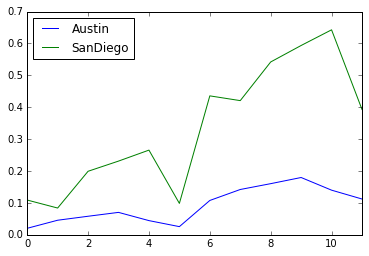

In [95]:
X_hvac.plot()

In [65]:
from degree_days import *

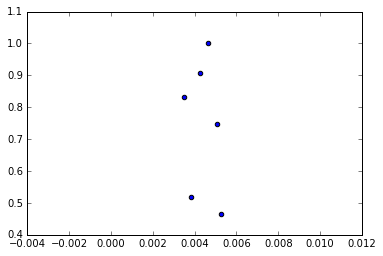

In [99]:
plt.scatter(X_df[:6]['Austin'],dds[2014]['Austin'][4:10] )
#dds[2014]['Austin'][4:9]

In [75]:
X_df[6:]['Austin']

6     0.107697
7     0.142078
8     0.160392
9     0.179684
10    0.140001
11    0.112244
Name: Austin, dtype: float64

In [100]:
dds[2014]['Austin']

[0.012706480304955527,
 0.07369758576874205,
 0.09148665819567979,
 0.30495552731893266,
 0.5184243964421855,
 0.832274459974587,
 0.9085133418043202,
 1.0,
 0.747141041931385,
 0.4650571791613723,
 0.054637865311308764,
 0.03430749682337993]

In [77]:
X_hvac_austin

matrix([[ 0.02039206,  0.04568984,  0.0581605 ,  0.07030242,  0.04450363,
          0.02562743,  0.10769739,  0.14207768,  0.16039202,  0.17968411,
          0.14000083,  0.11224388]])

In [78]:
Y_hvac_austin

matrix([[ 0.50037877],
        [ 0.25846533],
        [ 0.36190634],
        [ 0.18519378],
        [ 0.64164236],
        [ 0.91612977],
        [ 1.32820979],
        [ 0.23230988],
        [ 0.86287042],
        [ 0.81727218],
        [ 1.13134948],
        [ 0.50779661],
        [ 0.34748687],
        [ 0.71765476],
        [ 0.31554283],
        [ 1.34911238],
        [ 0.97815815],
        [ 0.64037072],
        [ 0.2986775 ],
        [ 0.33094265],
        [ 0.90171486],
        [ 0.76396439],
        [ 0.14776769],
        [ 0.60846783],
        [ 0.40045271],
        [ 0.5417921 ],
        [ 0.78199659],
        [ 0.78248434],
        [ 0.54114435],
        [ 0.39263816],
        [ 0.85281926],
        [ 1.60223993],
        [ 1.42374286],
        [ 0.98733554],
        [ 0.93638901],
        [ 4.87566995],
        [ 0.64647819],
        [ 0.11859901],
        [ 0.86203369],
        [ 0.70657032],
        [ 1.19760582],
        [ 1.08471411],
        [ 0.4528264 ],
        [ 0

In [101]:
idx_user

In [102]:
data_user